In [1]:
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from dredFISH.Analysis.__init__plots import *
from dredFISH.Analysis import basicu 
from model import *
from allen_data_iterators import DataIterCached

In [2]:
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference' + '/10X/genes.npy' 
tenx_genes = np.load(f)
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference' + '/SmartSeq/genes.npy' 
smrt_genes = np.load(f)

np.all(tenx_genes == smrt_genes)

genes = tenx_genes
genes.shape

(10861,)

In [26]:
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference' + '/10X/probe_constraints.npy' 
prbe_cnstrnts = np.load(f)
prbe_cnstrnts.shape
prbe_cnstrnts

array([ 36, 250,  59, ..., 199, 124,  92])

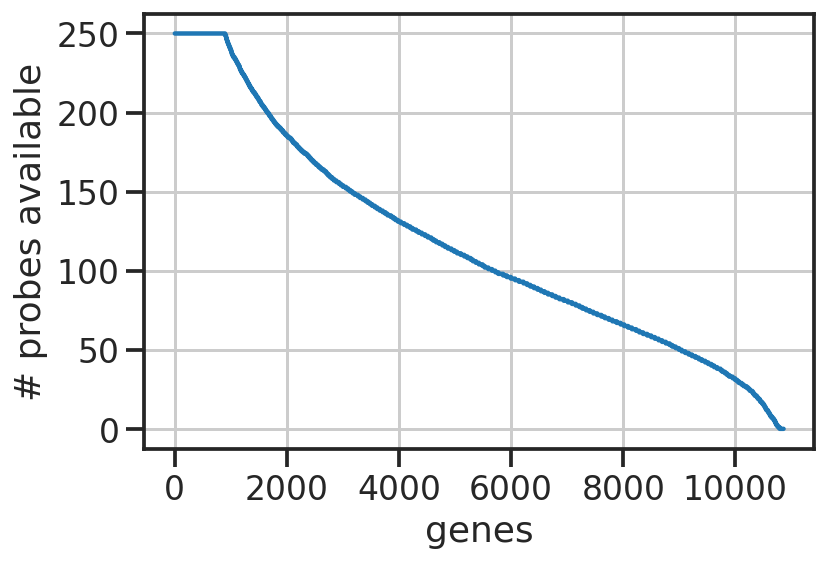

In [29]:
fig, ax = plt.subplots()
ax.plot(np.sort(prbe_cnstrnts)[::-1])
ax.set_xlabel('genes')
ax.set_ylabel('# probes available')
plt.show()

# outputs
- embmat - a (ncell, nbit (24)) matrix
- model - a pytorch format
- results -- some summary statistics

- meta (what are these parameters?)
    - max-half_nrml-90000.0-1.27E+05-24-0-2.60E-09-0.01-1.0
    - max-half_nrml-90000.0-1.32E+05-24-0-3.40E-09-0.01-1.0
    
# input
- allen_data_iterator
    - original: `/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference`
    - cached: `/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/cache/_2`

# the embmat

In [3]:
f = './results/embmat=max-half_nrml-90000.0-1.27E+05-24-0-2.60E-09-0.01-1.0.json'
with open(f, 'r') as fh:
    embmat = json.load(fh)
    embmat = np.array(embmat)
    print(embmat.shape)

(10861, 24)


In [4]:
f = './results/result=max-half_nrml-90000.0-1.27E+05-24-0-2.60E-09-0.01-1.0.json'
with open(f, 'r') as fh:
    res = json.load(fh)
    # res = np.array(res)
    # print(res.shape)
list(res.keys())

['0',
 '200',
 '400',
 '600',
 '800',
 '1000',
 '1200',
 '1400',
 '1600',
 '1800',
 '2000']

<AxesSubplot:>

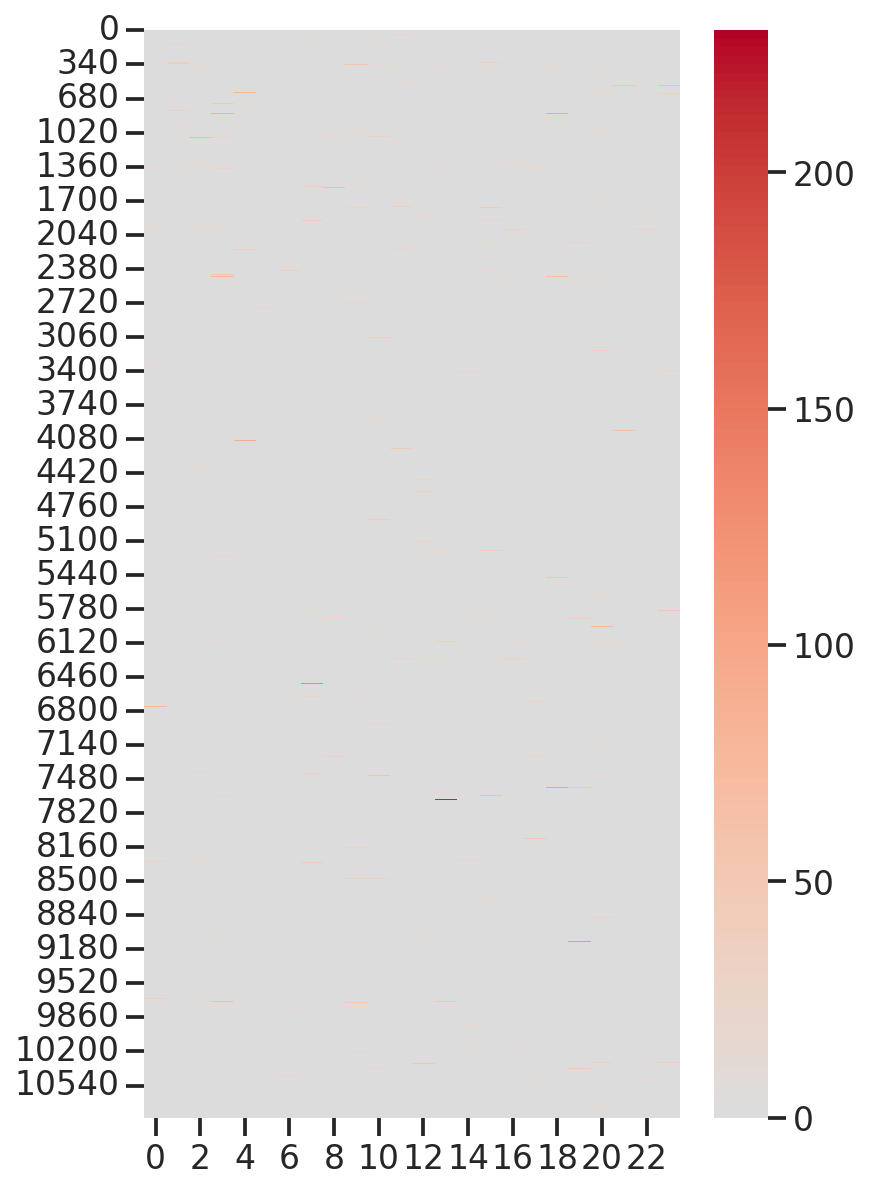

In [5]:
fig, ax = plt.subplots(figsize=(6,10))
sns.heatmap(embmat, 
            # (embmat>0)
            ax=ax,
            cmap='coolwarm',
            center=0,
           )

# the results (statistics)

# the model

- filename {pooling type} {noise type} {max expression} {min position} {number of bits} {dropout} {penalty factors}
- self.name= '-'.join([str(i) for i in (reduction, cnst, mxpr, '%.2E'%min_pos, n_bit, drprt, '%.2E'%lmd1, lmd2, lmd3)])
- max, half_nrml, 90000.0, 1.27e+05, 24, 0, 2.60e-09, 0.01, 1.0

In [7]:
# prep the model
f = './results/model=max-half_nrml-90000.0-1.27E+05-24-0-2.60E-09-0.01-1.0.pt'
reduction, cnst, mxpr, min_pos, n_bit, drprt, lmd1, lmd2, lmd3 = os.path.basename(f)[len('model='):].replace('E-0', 'enp0').split('-')

min_pos = np.float64(min_pos)
lmd1 = np.float64(lmd1.replace('enp', 'E-0'))
reduction, cnst, mxpr, min_pos, n_bit, drprt, lmd1, lmd2, lmd3

('max', 'half_nrml', '90000.0', 127000.0, '24', '0', 2.6e-09, '0.01', '1.0.pt')

In [8]:
# understand the model
data_iter= DataIterCached(n_iter= 2000)
model = CellTypeNet(
                   n_gns=     data_iter.current['tenx_ftrs'].shape[1], # num genes
                   n_cat=     data_iter.labl_map.shape[1],             # num categories (celltypes)
                   lab_map=   data_iter.labl_map,                      # label map (fine to course)
                   cnst=      'half_nrml',                             # reasonable val (???? not used)
                   reduction= 'max',                                   # mean or max pooling
                   n_bit=     24,                                      # fixed
                   min_pos=   min_pos,                                 # -- tune; minimum position, diff from top gene counts
                   lmd1=      lmd1,                                    # -- tune; penalty factor on margin loss
                   lmd2=      1e-2,                                    # penalty factor on 10X correction
                   lmd3=      1e-0,                                    # penalty factor on discriminator
                   drprt=     0                                        # dropout proportion applied at the gene level
                  )

model.load_state_dict(torch.load(f))
model.eval()


CellTypeNet(
  (enc): Embedding(10861, 24)
  (dcd): Embedding(24, 377)
  (drp): Dropout(p=0, inplace=False)
  (nrm): InstNrm()
  (lab): LabPool()
  (dsc): Sequential(
    (0): Linear(in_features=24, out_features=7, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=7, out_features=1, bias=True)
  )
)

In [9]:
for i,data in tqdm(enumerate(data_iter)):
    tenx_ftrs = data['tenx_ftrs']
    smrt_ftrs = data['smrt_ftrs']
    print(tenx_ftrs.shape)
    break


0it [00:00, ?it/s]

torch.Size([2150, 10861])


In [10]:
model.enc.weight

Parameter containing:
tensor([[-1.0620, -1.5428, -2.7739,  ..., -0.0180,  2.0224, -2.2374],
        [-0.4202, -1.3261, -2.3463,  ..., -1.9358, -2.0342, -0.9418],
        [-1.7635, -3.2656, -3.2723,  ...,  9.5451,  2.0099, -2.4163],
        ...,
        [-2.6365, -2.3680, -3.6406,  ...,  1.4127,  0.2609, -1.4403],
        [-0.8762, -4.2384, -3.6186,  ...,  1.8168, -1.7166, -2.2938],
        [-0.2856, -0.7173, -4.7967,  ..., -2.1484, -4.7533, -1.5274]],
       requires_grad=True)

In [11]:
embmat

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 25.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [12]:
np.max(embmat), np.min(embmat), np.sum(embmat), mxpr

(230.0, 0.0, 89490.0, '90000.0')

In [13]:
tmp = model.enc.weight.exp()
tmp = tmp/tmp.sum() * float(mxpr)
tmp.round().detach()

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., 25.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

# check encoding matrix

In [14]:
pmat = pd.DataFrame(embmat, index=genes)
pmat

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Zfy1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kdm5d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eif2s3y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,25.0,0.0,0.0
Ddx3y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Usp9y,0.0,0.0,23.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lkaaear1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Oprl1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Myt1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pcmtd2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
for i, col in enumerate(pmat):
    _x = pmat[col]
    _x = _x[_x>0]
    print(i, len(_x), np.min(_x), np.max(_x), np.sum(_x))
    # sns.histplot(_x,)
    

0 249 1.0 179.0 3624.0
1 291 1.0 135.0 4203.0
2 317 1.0 86.0 3872.0
3 267 1.0 86.0 3585.0
4 321 1.0 124.0 3849.0
5 209 1.0 230.0 3240.0
6 239 1.0 108.0 2511.0
7 270 1.0 135.0 4031.0
8 232 1.0 105.0 3779.0
9 346 1.0 97.0 4291.0
10 335 1.0 162.0 3958.0
11 280 1.0 139.0 3635.0
12 308 1.0 92.0 3683.0
13 311 1.0 215.0 3454.0
14 265 1.0 119.0 3247.0
15 319 1.0 118.0 4424.0
16 234 1.0 140.0 3118.0
17 238 1.0 123.0 3510.0
18 280 1.0 226.0 3666.0
19 255 1.0 156.0 3265.0
20 354 1.0 121.0 4041.0
21 305 1.0 138.0 4567.0
22 315 1.0 139.0 4180.0
23 283 1.0 130.0 3757.0


In [16]:
pm = sns.color_palette('husl', n_colors=24)
pm

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.9699521567340649, 0.4569882390259858, 0.36385324448493633),
 (0.903599057664843, 0.511987276335809, 0.19588350060161624),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.6666319352625271, 0.6197366714155128, 0.19396267878823373),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.49382662140640926, 0.6649121332643736, 0.19300804648700284),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.20312757197899856, 0.6881249249803418, 0.5177618167447304),
 (0.20703735729643508, 0.6824290013722435, 0.5885318893529169),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21387918628643265, 0.6720135434784761, 0.693961140878689),
 (0.21786710662428366, 0.6656671601322255, 0.7482809385065813),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.4768773964929644, 0.5974418160509446, 0.9584992622400258),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.774710828527837, 0.49133823414365724, 0.9580114121137316),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491),
 (0.9633321742064956, 0.40643825645731757, 0.7592537599568671),
 (0.9656056642634557, 0.4245907603266889, 0.6579786740552919)]

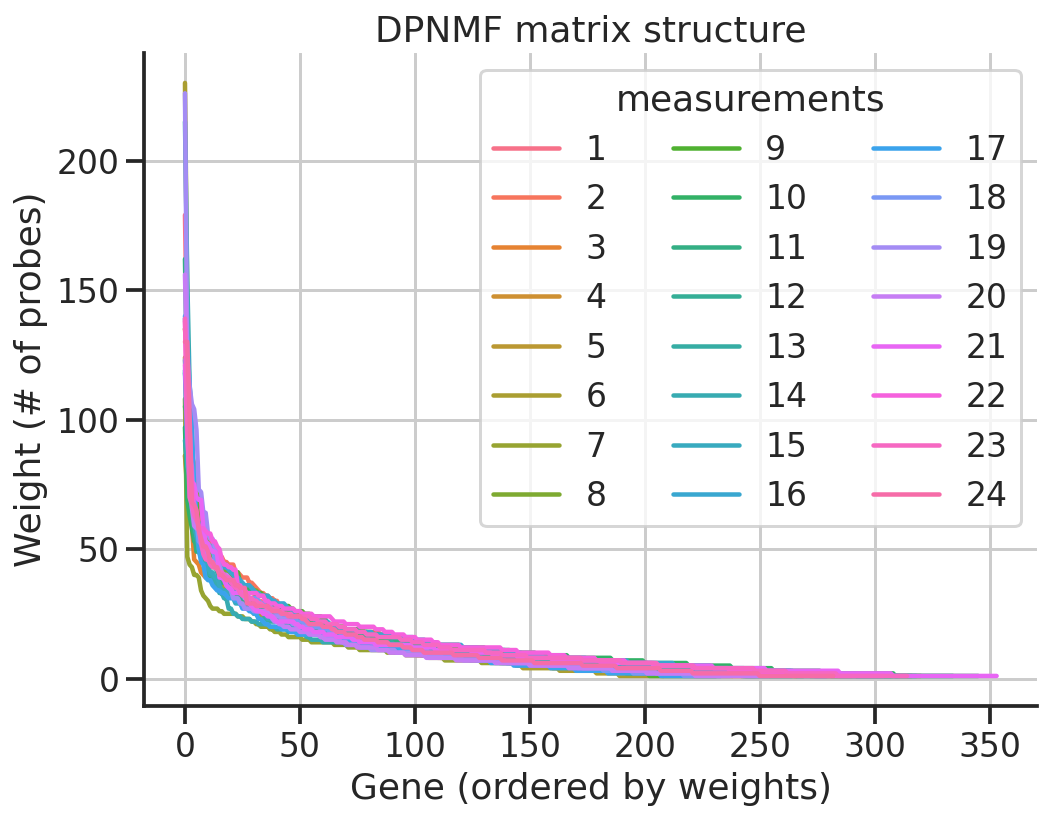

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
for i, col in enumerate(pmat):
    _x = pmat[col]
    _x = np.flip(np.sort(_x[_x>0])) #[:,:,-1]
    ax.plot(_x, color=pm[i], label=f'{i+1}')
ax.set_xlabel('Gene (ordered by weights)')
ax.set_ylabel('Weight (# of probes)')
sns.despine(ax=ax)
ax.set_title('DPNMF matrix structure')
ax.legend(ncol=3, title='measurements')

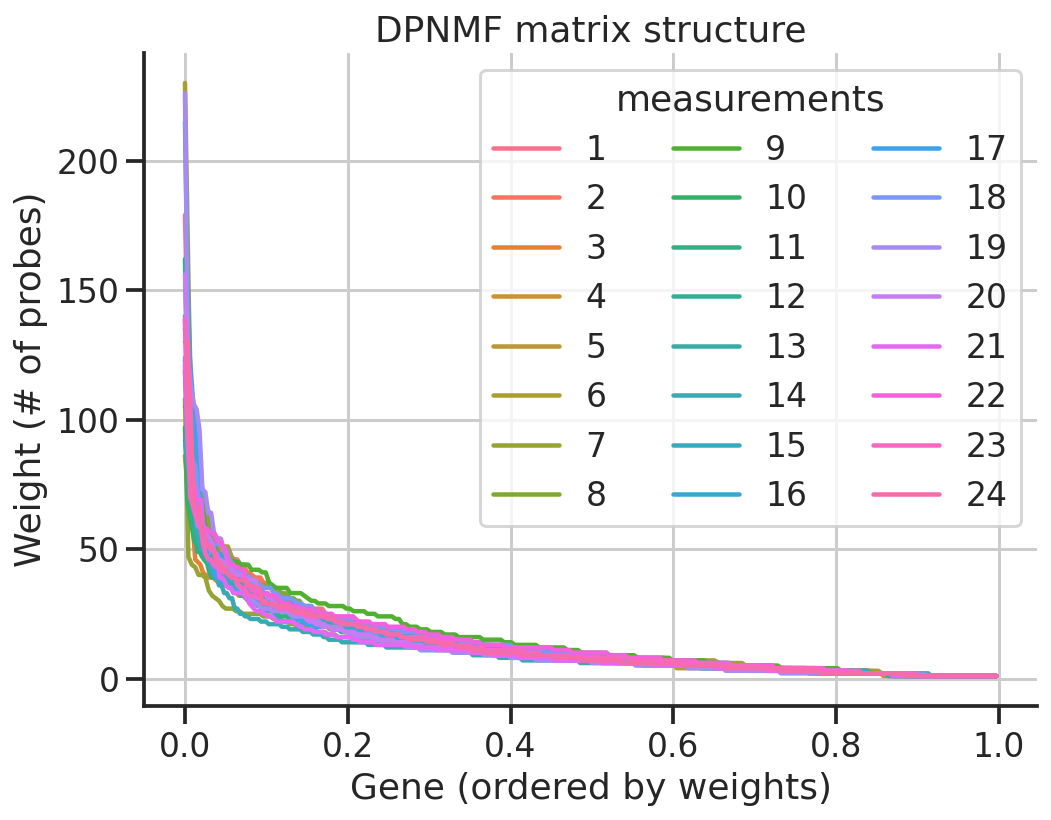

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
for i, col in enumerate(pmat):
    _x = pmat[col]
    _x = np.flip(np.sort(_x[_x>0])) #[:,:,-1]
    # _x = np.log10(_x+1)
    ax.plot(np.arange(len(_x))/len(_x), _x, color=pm[i], label=f'{i+1}')
ax.set_xlabel('Gene (ordered by weights)')
ax.set_ylabel('Weight (# of probes)')
sns.despine(ax=ax)
ax.set_title('DPNMF matrix structure')
ax.legend(ncol=3, title='measurements')

In [19]:
(pmat.sum(axis=1) == 0).sum(), (pmat.sum(axis=1) > 0).sum(), len(pmat)

(8009, 2852, 10861)

In [30]:
nzero_prbe_cond = pmat.sum(axis=1) > 0
pospmat = pmat[nzero_prbe_cond]

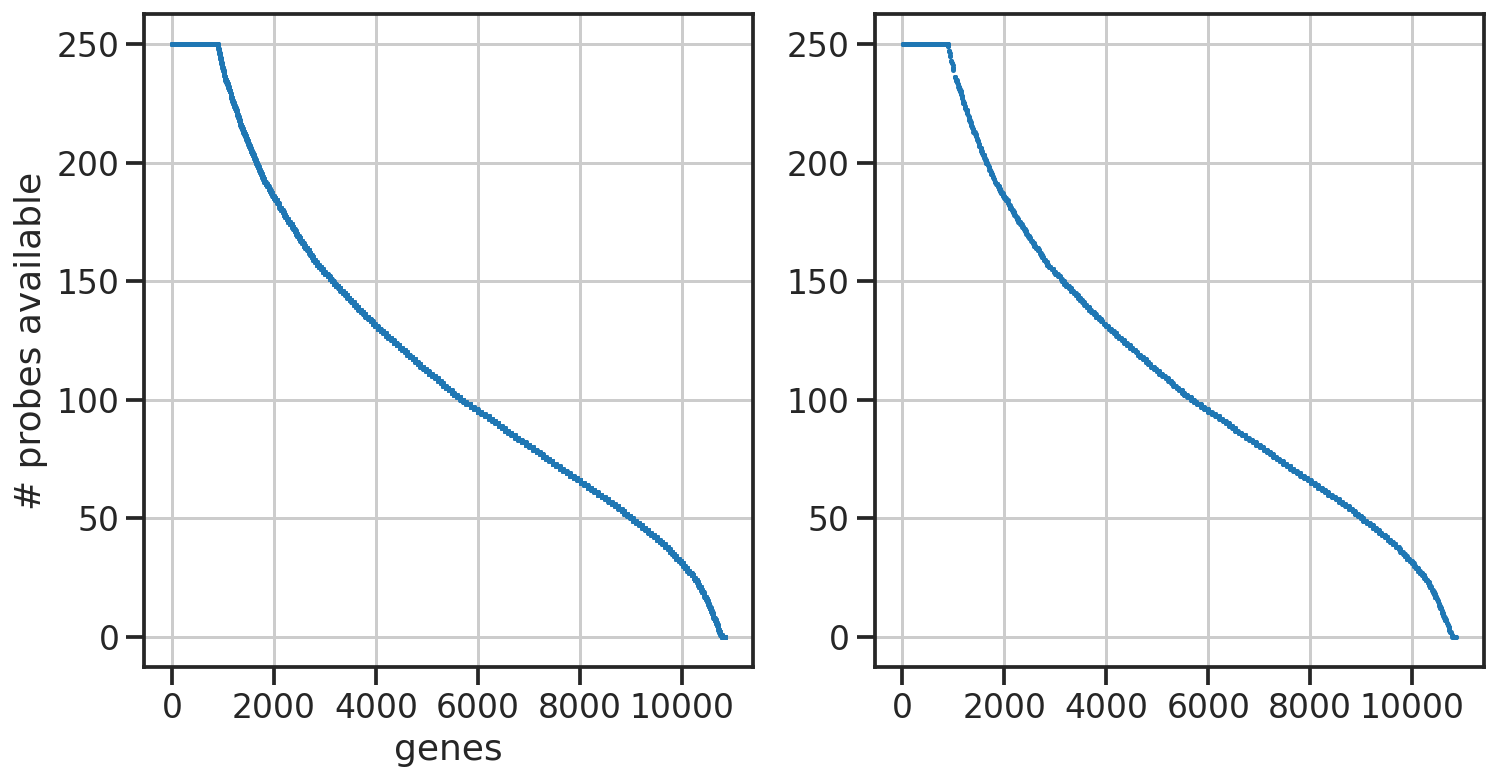

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
order = np.argsort(prbe_cnstrnts)[::-1]
ax = axs[0]
ax.scatter(np.arange(len(prbe_cnstrnts)), prbe_cnstrnts[order], s=1)
ax.set_xlabel('genes')
ax.set_ylabel('# probes available')

ax = axs[1]
ax.scatter(np.arange(len(prbe_cnstrnts))[nzero_prbe_cond[order]], prbe_cnstrnts[order][nzero_prbe_cond[order]], s=1)
plt.show()

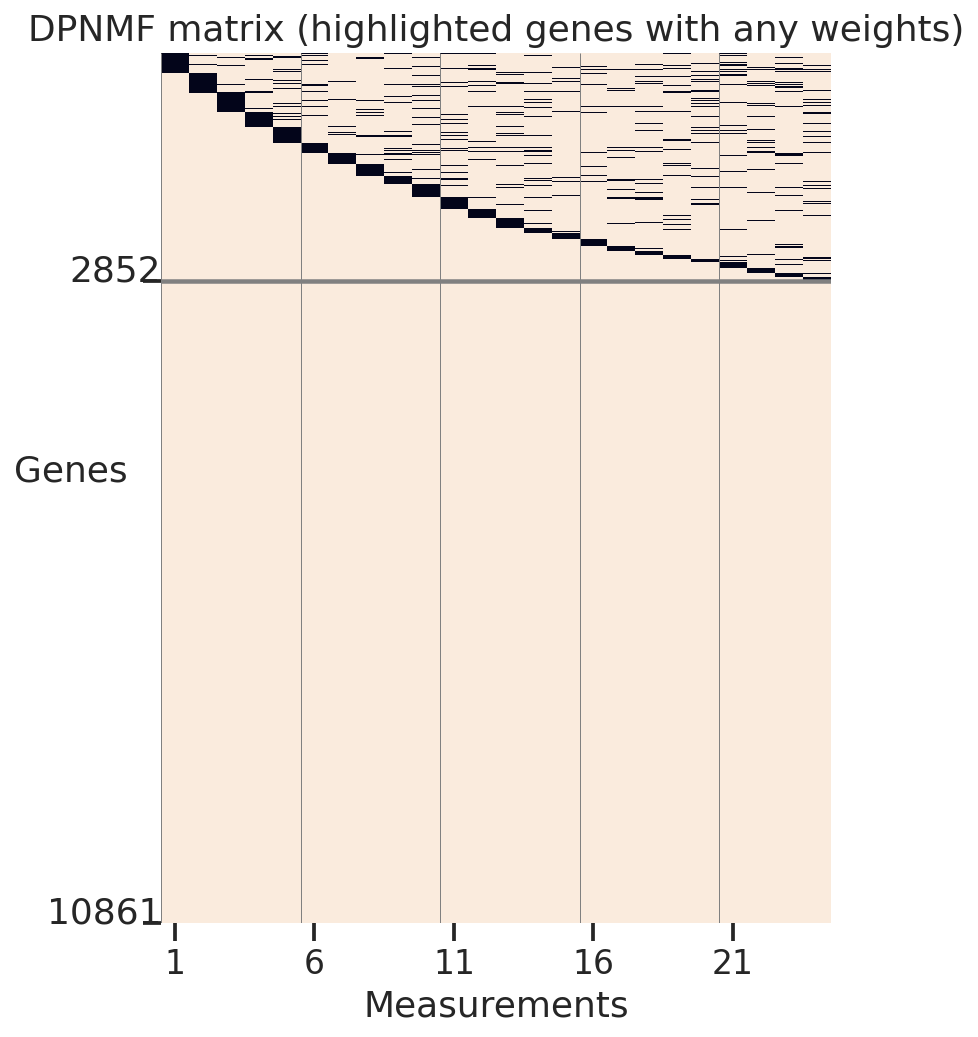

In [21]:

with sns.axes_style('ticks'):
    # zero count does not matter
    bpmat = (pospmat > 0).astype(int)

    _mat, _row, _col = basicu.diag_matrix_rows(bpmat.values)
    _zeromat = pmat[pmat.sum(axis=1) == 0]
    nmat = len(_mat)
    nzeromat = len(_zeromat)
    ntotal = nmat + nzeromat

    fig, ax = plt.subplots(figsize=(6,8))
    sns.heatmap(pd.DataFrame(np.vstack([_mat, _zeromat]), columns=(_col+1)),
                cbar=False,
                xticklabels=5, 
                cmap='rocket_r',
                ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
    ax.set_yticks([nmat, ntotal])
    ax.text(0, nmat, nmat, ha='right')
    ax.text(0, ntotal, ntotal, ha='right')
    
    ax.axhline(nmat, color='gray')
    ax.vlines(np.arange(0,24,5), 0, ntotal, color='gray', linewidth=0.5)
    ax.set_xlabel('Measurements')
    ax.set_ylabel(f'Genes', rotation=0, ha='right')
    ax.set_title('DPNMF matrix (highlighted genes with any weights)')
    plt.show()

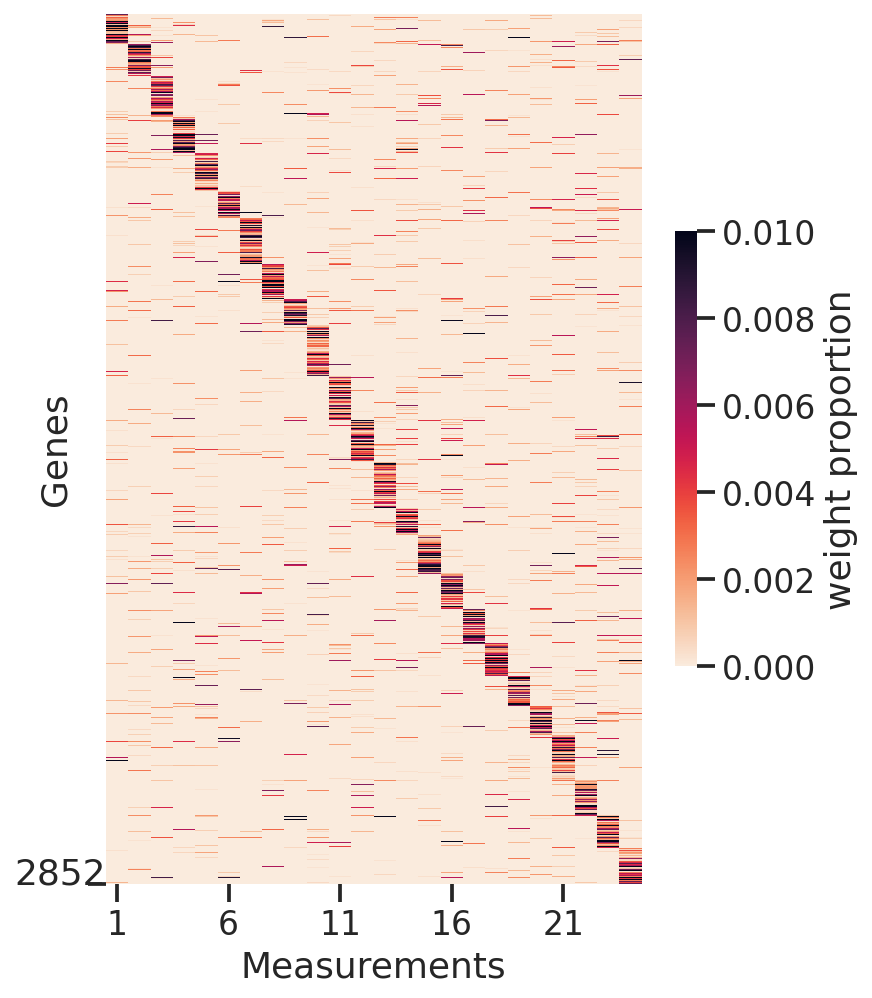

In [22]:
fpmat = pospmat.divide(pospmat.sum(axis=0), axis=1)
# fpmat = np.log(fpmat+1)
# normpmat = np.log10(pmat+1)
with sns.axes_style('ticks'):
    _mat, _row, _col = basicu.diag_matrix_rows(fpmat.values)
    nmat = len(_mat)

    fig, ax = plt.subplots(figsize=(6,8))
    sns.heatmap(pd.DataFrame(_mat, columns=_col+1), 
                xticklabels=5, 
                cmap='rocket_r',
                ax=ax, vmax=0.01, cbar_kws=dict(shrink=0.5, label='weight proportion')
               )
    ax.set_xlabel('Measurements')
    ax.set_ylabel('Genes')
    ax.set_yticks([nmat])
    ax.text(0, nmat, nmat, ha='right')
    plt.show()

# check cell type matrix